In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import modules.eda as Detective
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

Đọc dữ liệu từ project 1 lên và sắp xếp lại dữ liệu

In [3]:
reviews = pd.read_csv("./data/normalize_reviews.csv").fillna("")
reviews = reviews[['raw_comment', 'normalized_comment', 'emoji', 'label']]

reviews.head()

raw_comment  \
0                                                      
1  Shop giao nhầm size. Áo from khá rộng nh...   
2  Áo form ổn. Khá xinh. Nhưng mà giao hàn...   
3  Áo đẹp\nNhưng tay áo 1 bên trắng 1 bên...   
4  Áo 2 lớp nhưng mỏng, có nhiều chỉ thu...   

                                  normalized_comment emoji  label  
0                                                               0  
1  giao nhầm size áo from khá rộng nhưng k...            0  
2  áo form ổn khá xinh nhưng mà giao hàng ...            0  
3  áo đẹp nhưng tay áo bên trắng bên vàn...            0  
4  áo lớp nhưng mỏng có nhiều chỉ thừa...            0

Ở phần này, chúng ta sẽ tập trung đi sâu vào mặt khám phá các từ ngữ, bây giờ chúng ta cùng xem bức tranh tổng thể trước. Cụ thể là trong dataset của chúng ta đâu là các từ vựng phổ biến. Chúng ta thực hiền điều này bằng một Python's package là **Wordcloud**:
  ```shell
  pip install wordcloud
  ```

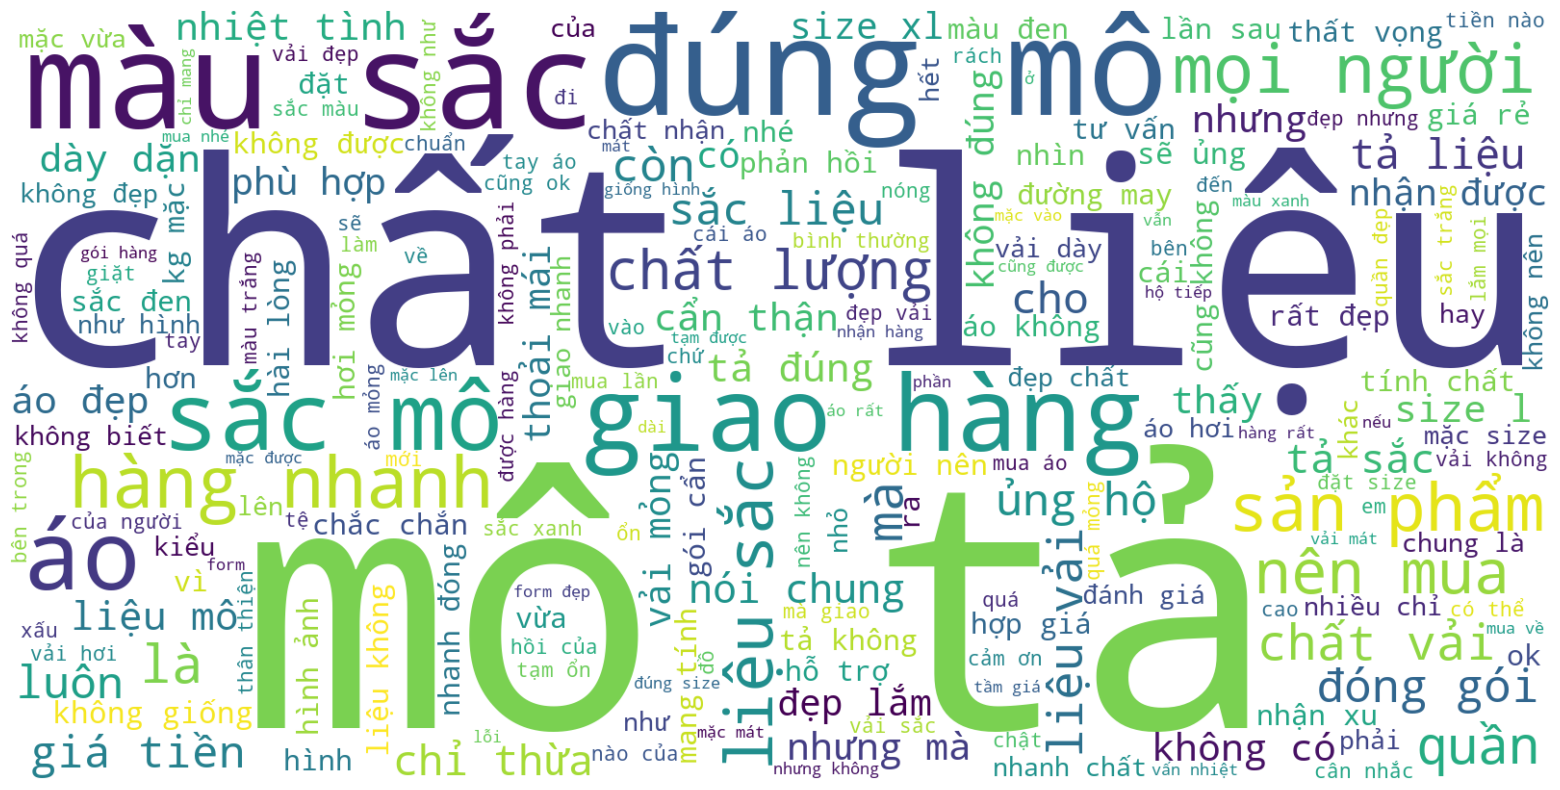

In [4]:
Detective.commentWordCloud(reviews['normalized_comment'])

> **Nhận xét**:
> * Nhìn chung, ở bước tiền xử lí dữ liệu ta đã xử lí khá tốt.
> * WordCloud tiện lợi trong việc cho ta cái nhìn tổng quát trên dữ liệu dạng text, cho ta thấy được các từ nào chồng chéo lên nhau trên các class.
> * Ngoài ra, nó giúp ta liệt kệ được rõ ràng các **từ ghép** quan trọng, các từ ghép sẽ có tần số xuất hiện gần nhau nên sẽ có font-size giống nhau - điển hình ở đây ta thấy được các từ như: sản phẩm, giao hàng, chất lượng,... Tuy nhiên với tôi các từ này không đem lại nhiều giá trị cho lắm, vì đây là trang bán hàng, comment nào cũng sẽ có những từ này, tức chúng xuất hiện nhiều nhưng không quan trọng, các ta quan tâm là các từ thể hiện cảm xúc của khách hàng. Ta có thể xem xét bổ sung chúng vào stop word sau này.

Tiếp theo, ta sẽ xem xét các từ nào hay xuất hiện trên từng specific class theo feature `label`.

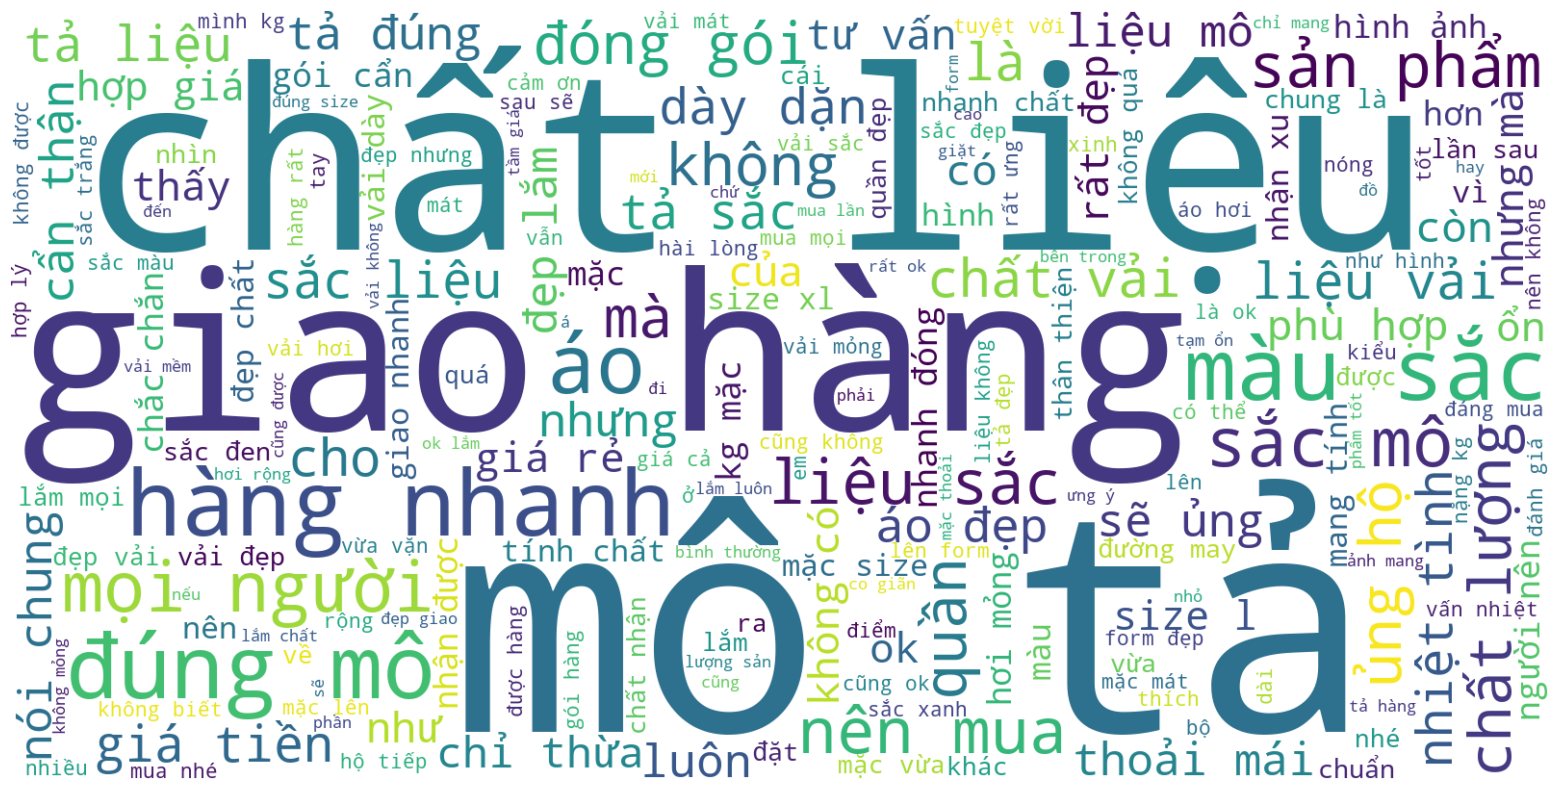

In [5]:
# xem theo label nhóm postive
Detective.commentWordCloud(reviews[reviews['label'] > 0]['normalized_comment'])

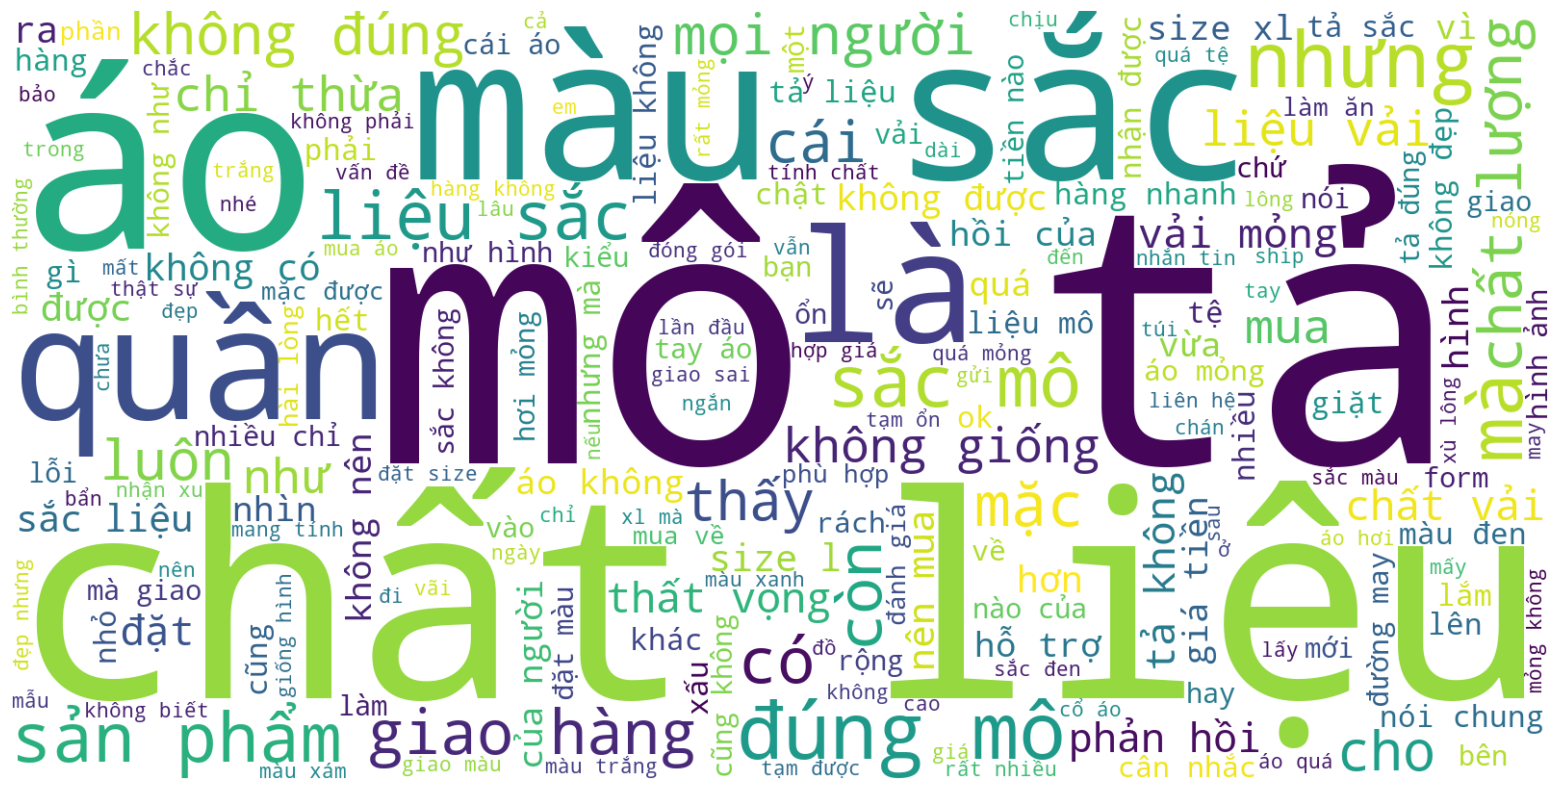

In [6]:
# xem theo label nhóm negative
Detective.commentWordCloud(reviews[reviews['label'] < 1]['normalized_comment'])

Để thấy được chi tiết sự khác nhau giữa về tần số mà các từ trong từng class xuất hiện. Một trong những cách khi gặp vấn đề này đối với cá nhân tôi là tôi sẽ áp dụng lần lượt các phương pháp là **Bag of words** rồi sau đó là **TF-IDF**, sau đó tôi chia thành các đoạn $[m, n]$ và thống kê frequency xem các từ nào mà nằm trong các đoạn này.

In [8]:
word_freq = Detective.createBagOfWordsFrequency(reviews['normalized_comment'])
print(len(word_freq))

3867


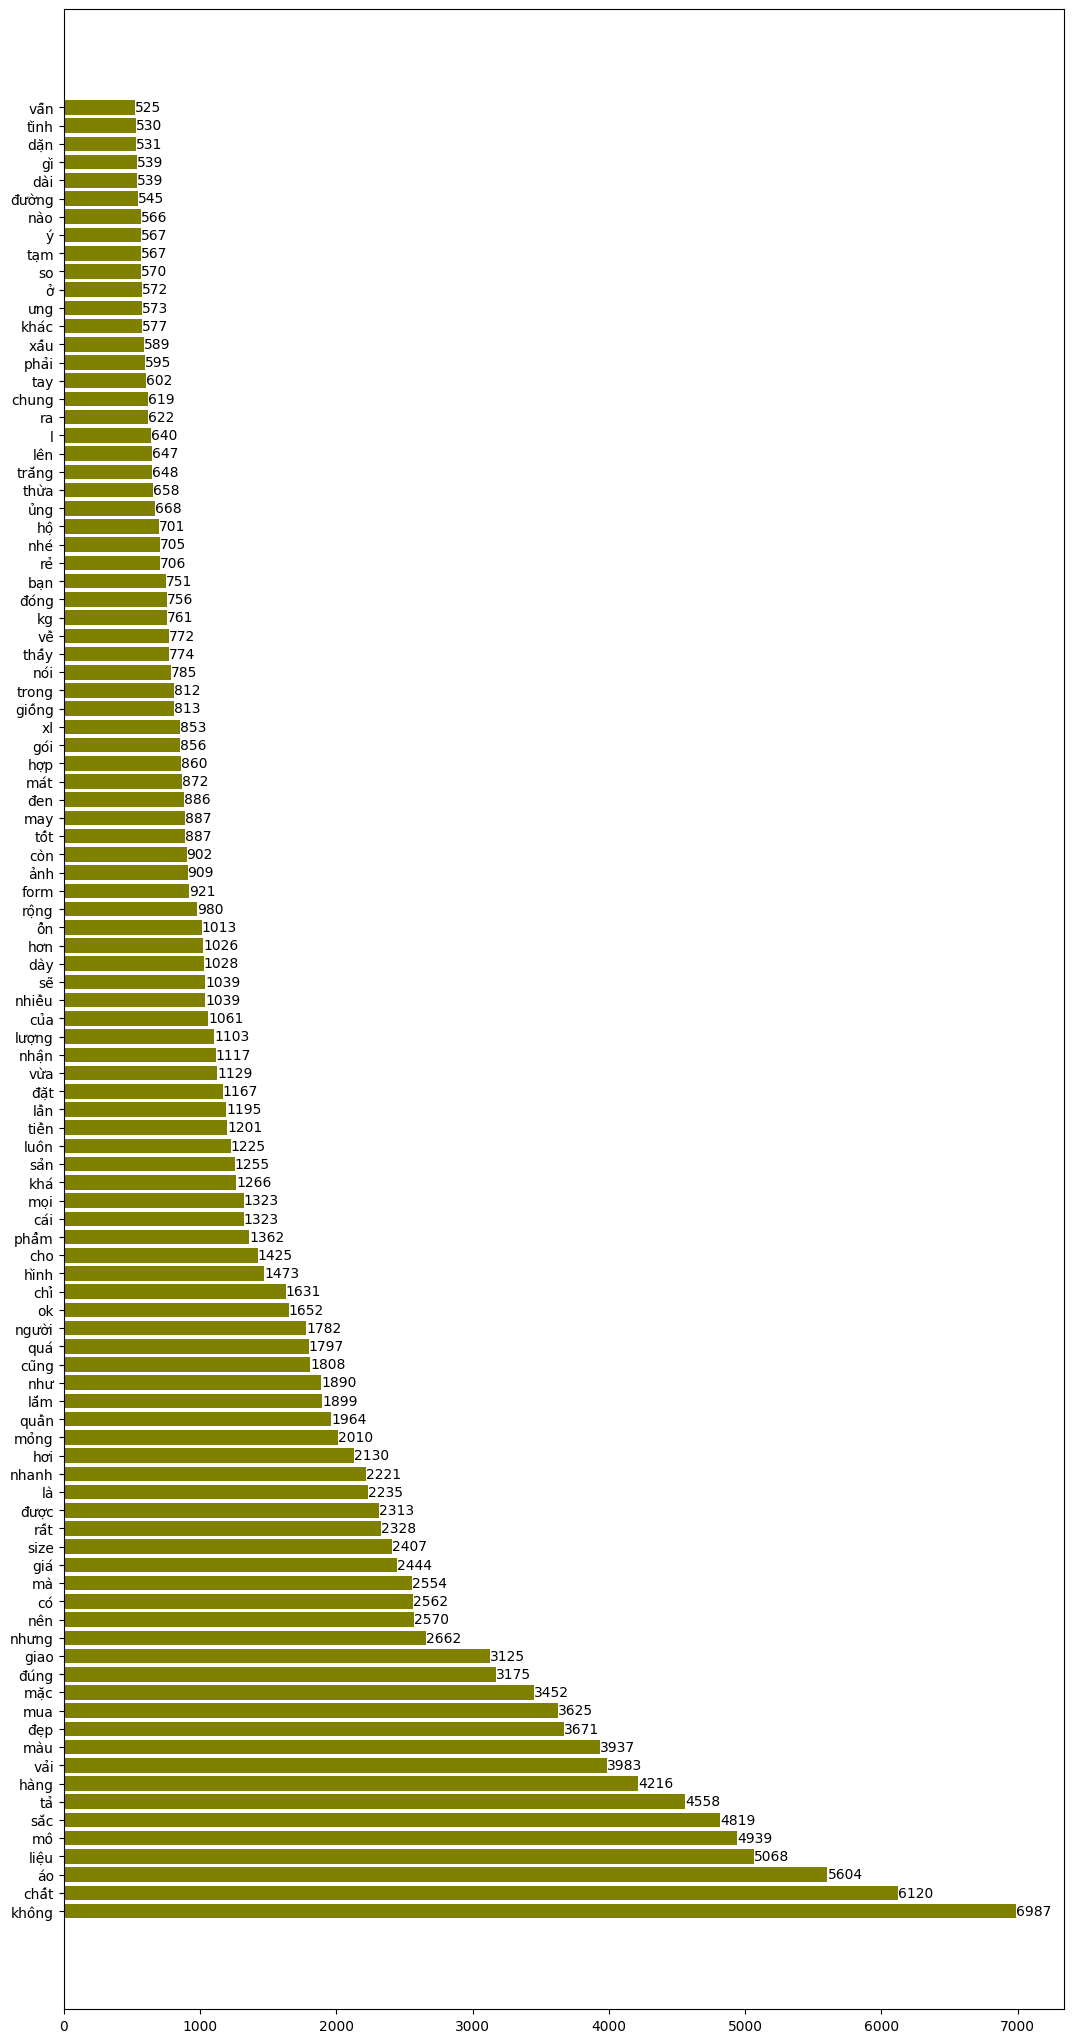

In [9]:
Detective.wordFrequencyBarplot(word_freq.head(100))

> **Nhận xét**:
> * Trên đây là 100 từ có tần số xuất hiện nhiều nhất 

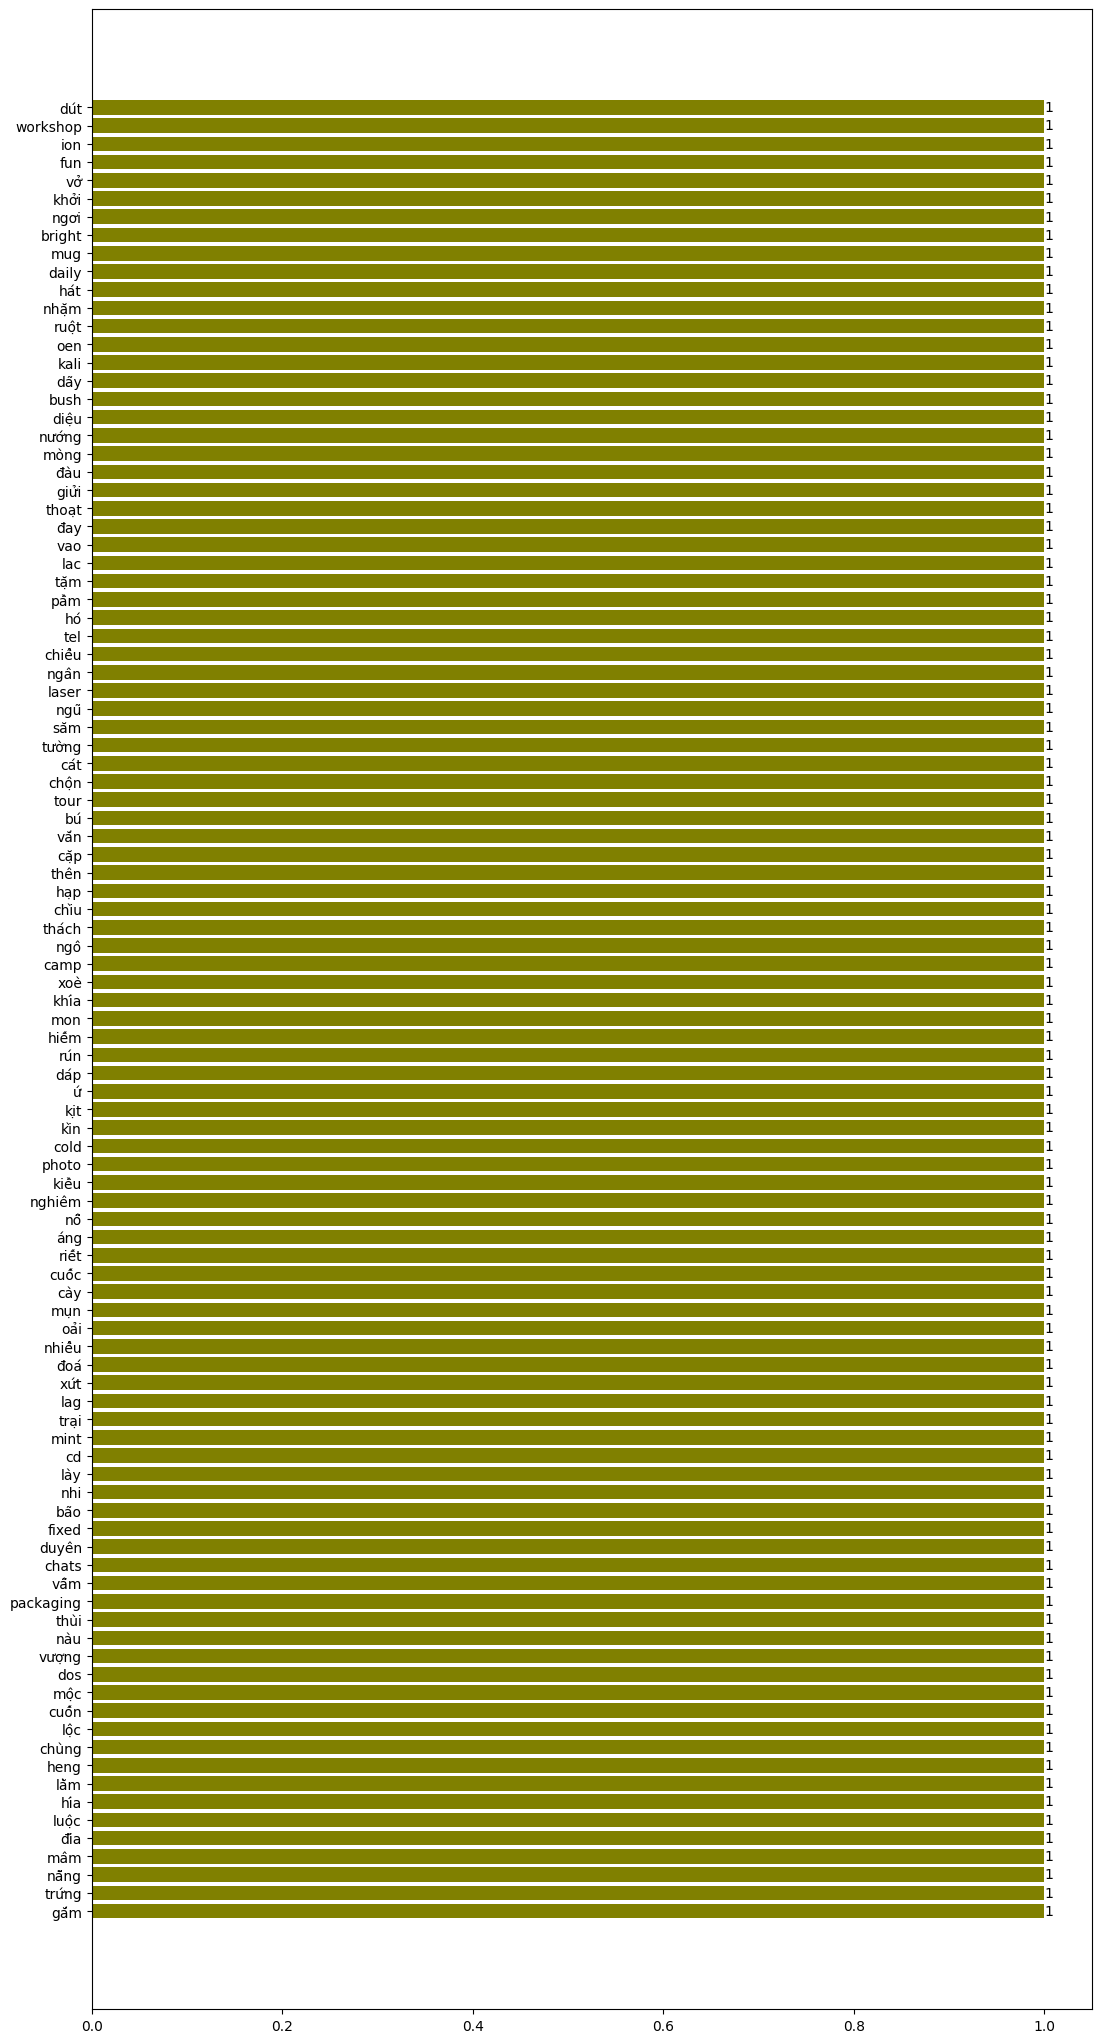

In [11]:
Detective.wordFrequencyBarplot(word_freq.tail(100))

> **Nhận xét**:
> * Đây là 100 từ có tần số xuất hiện ít nhất trong dataset. Chúng không đem lại tri thức cho model nhiều, chúng ta có thể cân nhắc trong việc xem xét và loại bỏ chúng khỏi các sentence để giảm tải input vector giúp model build nhanh hơn và chính xác hơn sau này.

Ta cũng nên kiểm tra xem các từ có tần số xuất hiện sao cho $\in [m, n]$ nào đó.

Number of samples: 124


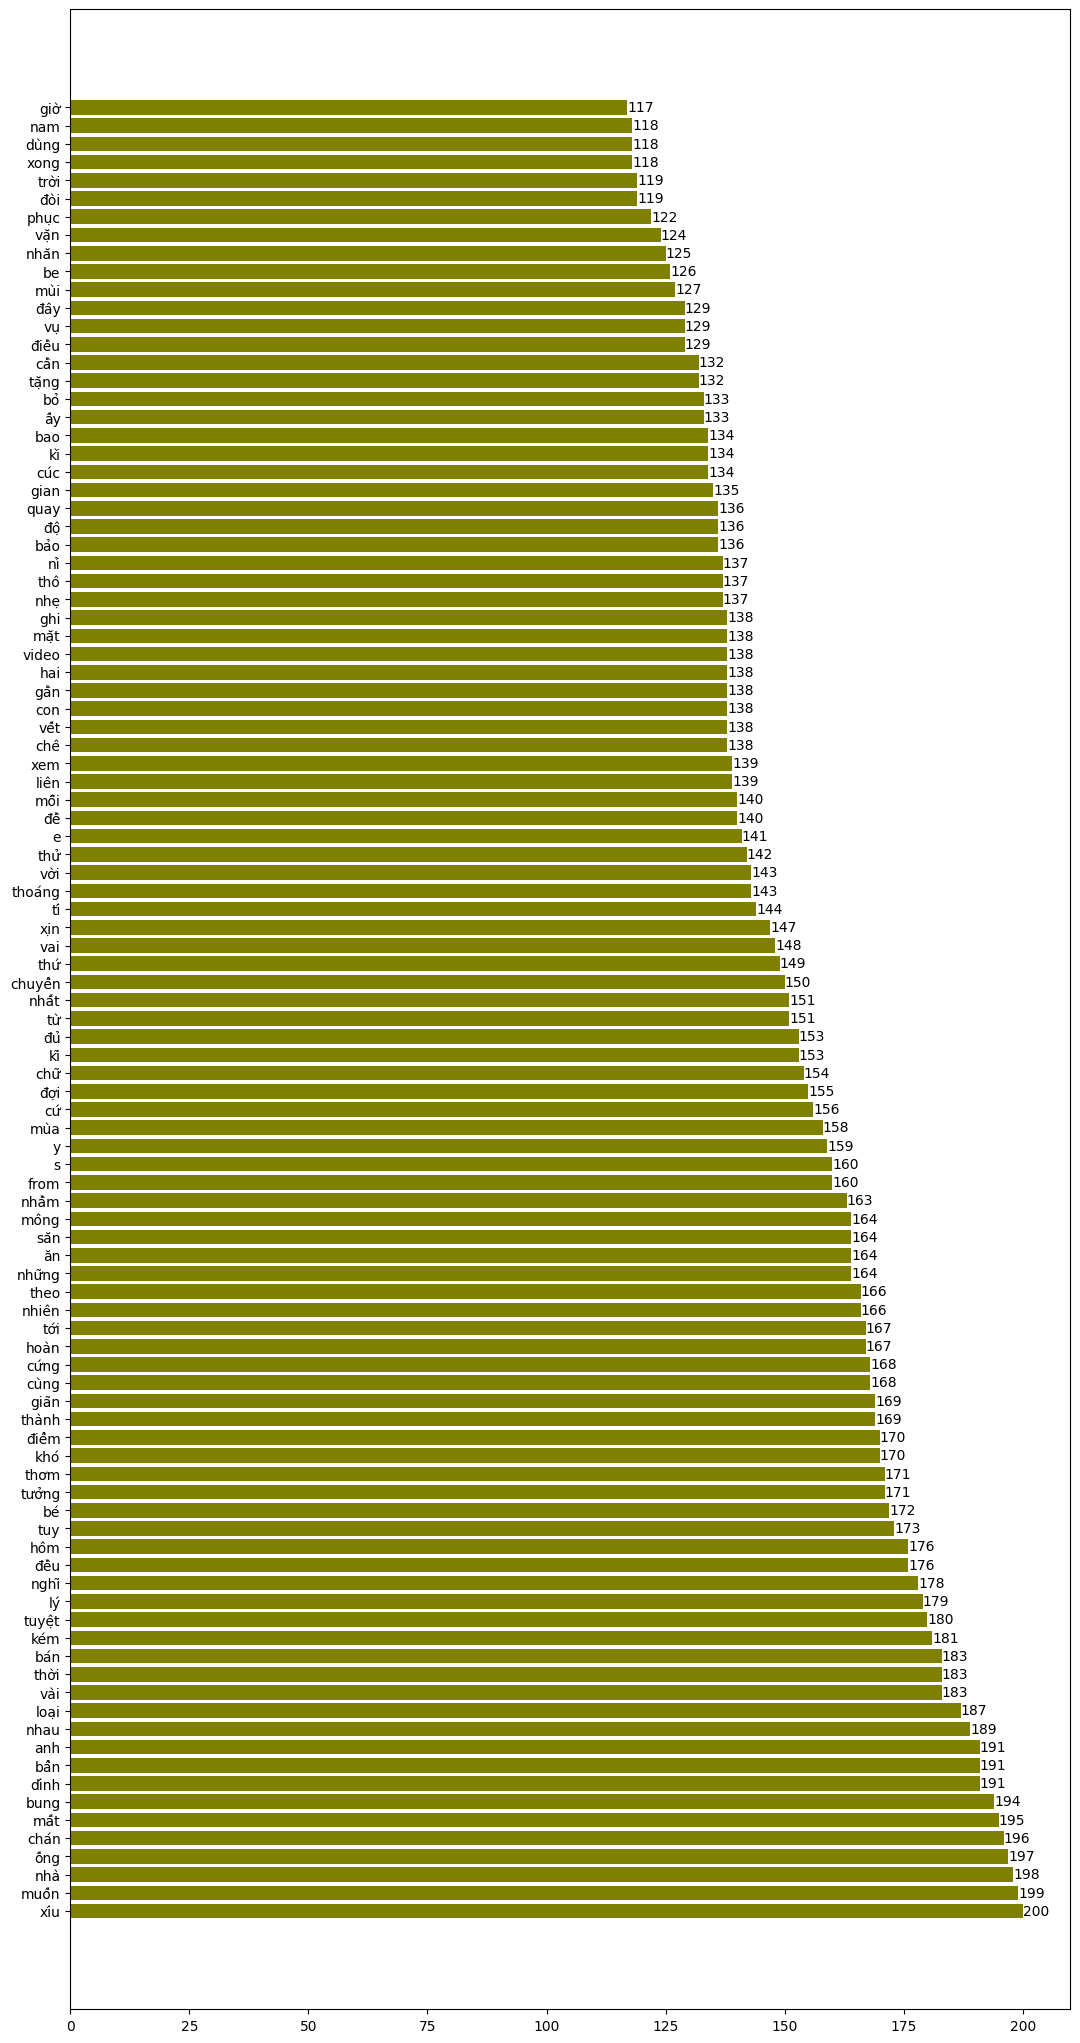

In [10]:
bt_100_200 = Detective.bagOfWordsGetRangeBased(word_freq, (100, 200))
print(f"Number of samples: {len(bt_100_200)}")
Detective.wordFrequencyBarplot(bt_100_200.head(100))

Number of samples: 95


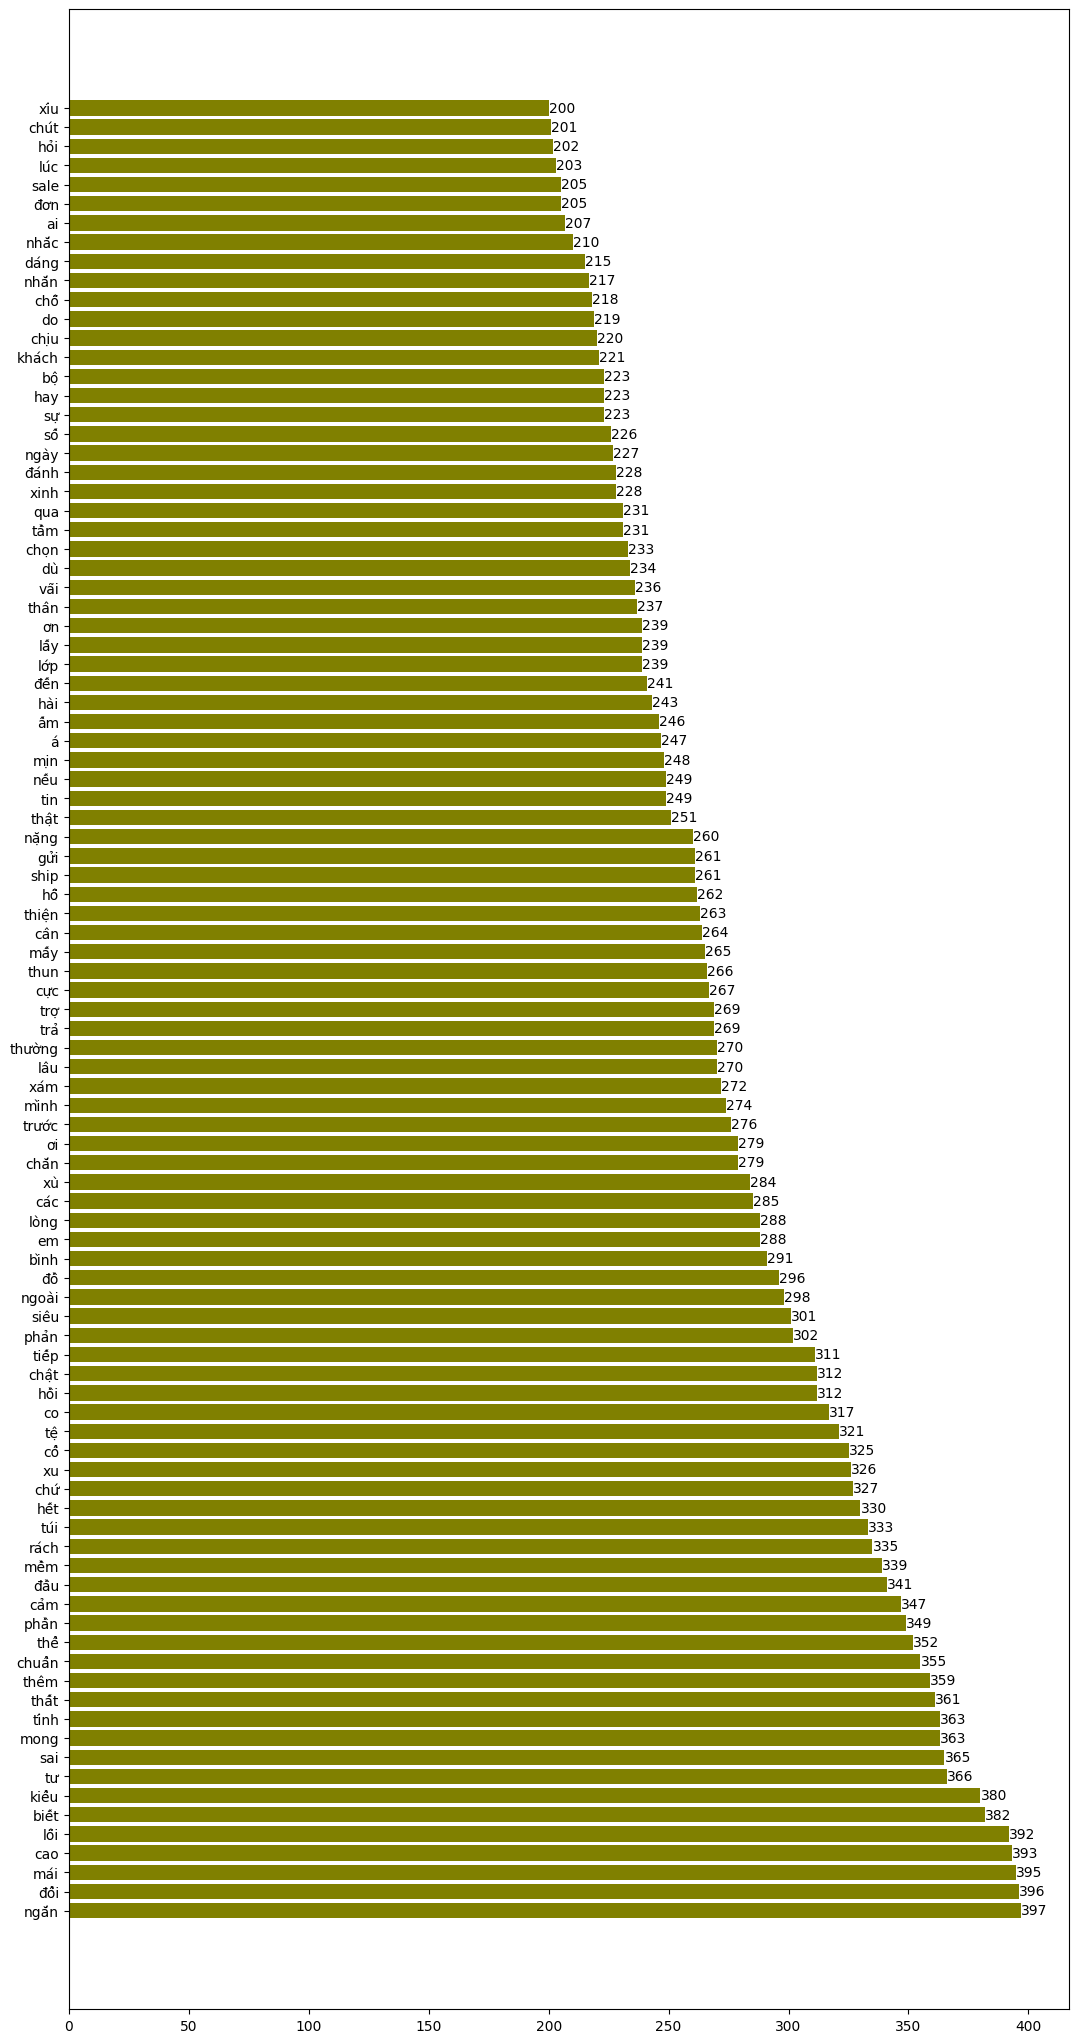

In [12]:
bt_200_400 = Detective.bagOfWordsGetRangeBased(word_freq, (200, 400))
print(f"Number of samples: {len(bt_200_400)}")
Detective.wordFrequencyBarplot(bt_200_400.head(100))

> **Nhận xét**:
> * Phía trên ta đã trực quan hóa các từng có tần số xuất hiện trong các khoảng khác nhau
> * Ta hoàn toàn có thể trực quan toàn bộ chúng lên một barplot và nhóm chúng lại thành các nhóm frequent range để xem có bao nhiêu từ có tần số như thế trong từng nhóm.

Tiếp theo đây, ta sẽ biểu diễn tần số xuất hiện của các từ theo các nhóm frequent range.

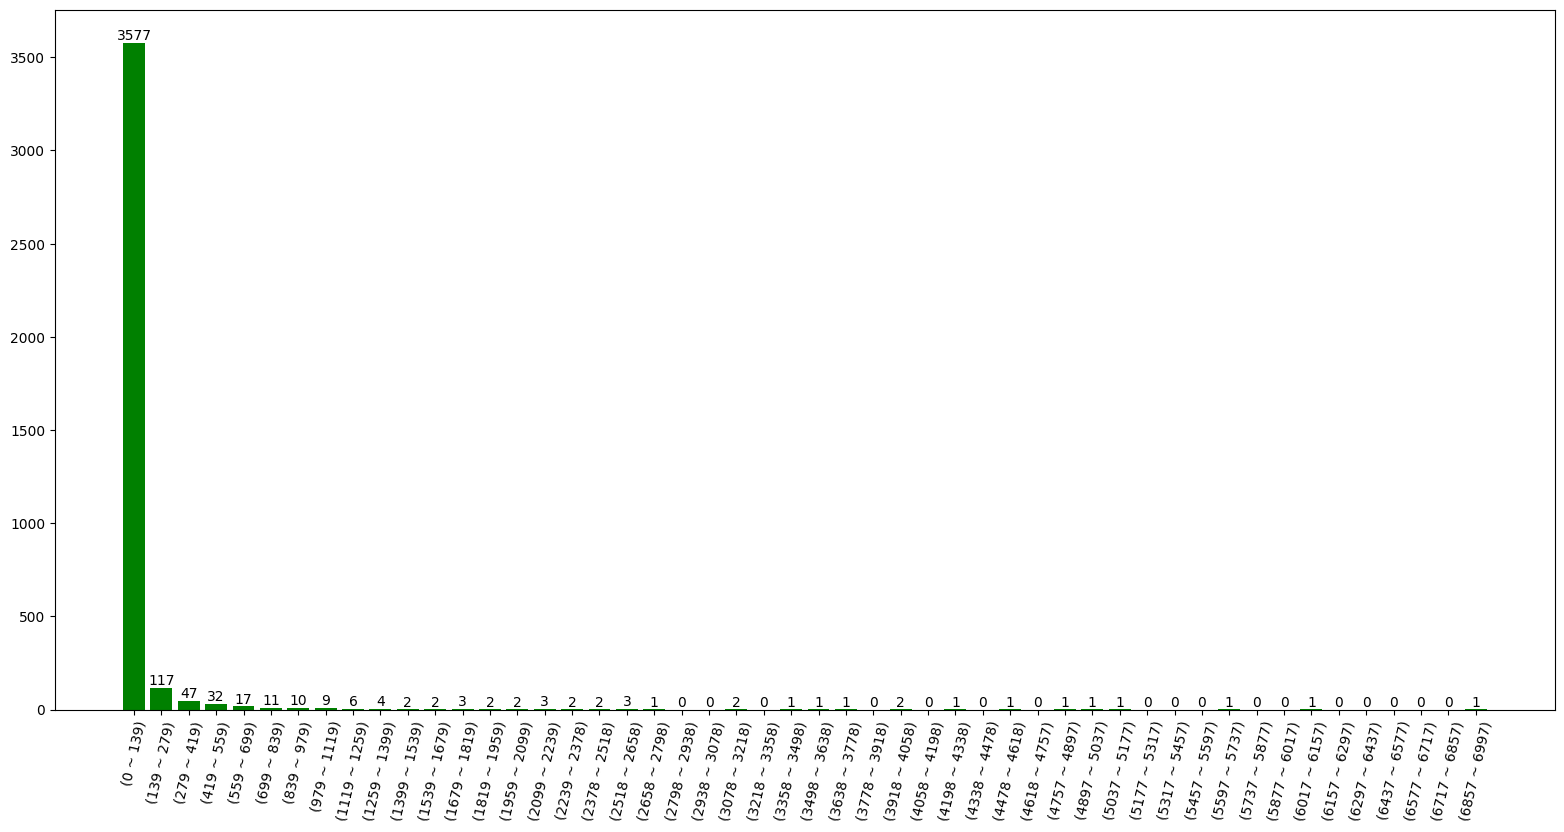

In [13]:
Detective.wordFrequencyGroupBarplot(word_freq['freq'].to_list())

> **Nhận xét**:
> * Nhìn vào biểu đồ barplot này, ta khó thấy được cách mà các từ được phân bổ như thế nào do cột đầu tiên đã chiếm đa số (trong trường hợp này ta dễ dàng thấy được do tôi đã thêm label vào cho từng cột), ta có một giải pháp là sử dụng log-scale.

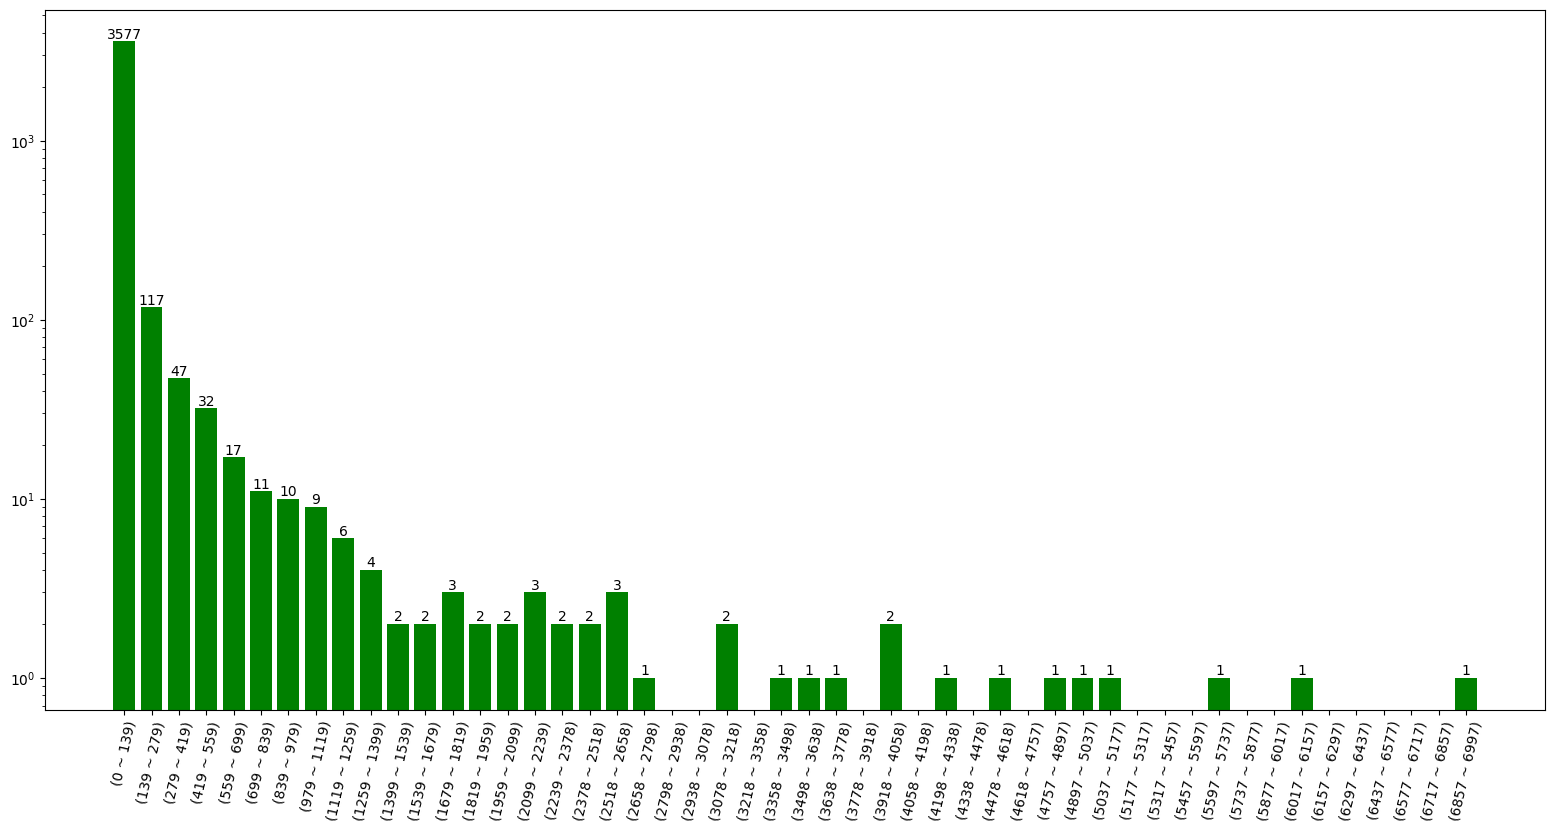

In [14]:
Detective.wordFrequencyGroupBarplot(word_freq['freq'].to_list(), True)

> **Nhận xét**:
> * Sau khi sử dụng hàm log để scale trên trục y, ta dễ dàng thấy hơn là đa phần các từ co tần số xuất hiện trong khoảng từ $[0, 146]$ là chủ yếu - có đến hơn 3500 từ nằm trong khoảng này, đây chính là một minh chứng cho một câu nói vui là "tuy tôi yếu nhưng anh em tôi đông".
> * Ngược lại, tuy có những từ  hầu như trong comment nào cũng xuất hiện nhưng chúng chỉ có một mình, về sau nếu ta có áp dụng N-Grams thì chúng là những thành phần lẻ loi không ai đi cùng.

Ta cũng có thể liệt kê ra các từ mà nằm trên cả hai class negative và postitive, việc này giúp ta phát hiện ra các từ nào có nguy cơ chồng chéo lên nhau và gây ra cho model sự bối rối trong việc đưa ra quyết định.

Chiến lược của ta sẽ như sau:
  * Trước tiên ta sẽ tạo ra một dictionary mà key là word, value là một mảng 2 chiều với phần tử đầu tiền là số lần từ đó xuất hiện ở class negative và phần tử thứ hai là số lần từ đó xuất hiện ở class positive.
  * Tiếp theo, ta duyệt lại dictionary này, chỉ lấy các từ mà có toàn bộ các phần từ trong mảng value đều khác 0, tức từ này xuất hiện ở cả hai class.
  * Cuối cùng ta sắp xếp lại chúng và trực quan hóa.

Và phần này, tôi cũng cần một package nữa là **plotly**: 
  ```shell
  pip install plotly
  ```

In [16]:
inter_words, neg_words, pos_words = Detective.intersectComplementWords(reviews)

In [17]:
# kiểm tra xem negative class và positive class có unique words không
print(f"Amount of negative words: {len(neg_words)}")
print(f"Amount of positive words: {len(pos_words)}")

Amount of negative words: 776
Amount of positive words: 994


> **Nhận xét**:
> * Vậy cả hai class negative và postive đều có các unique word, ta sẽ thử trực quan hóa chúng bằng bar plot.

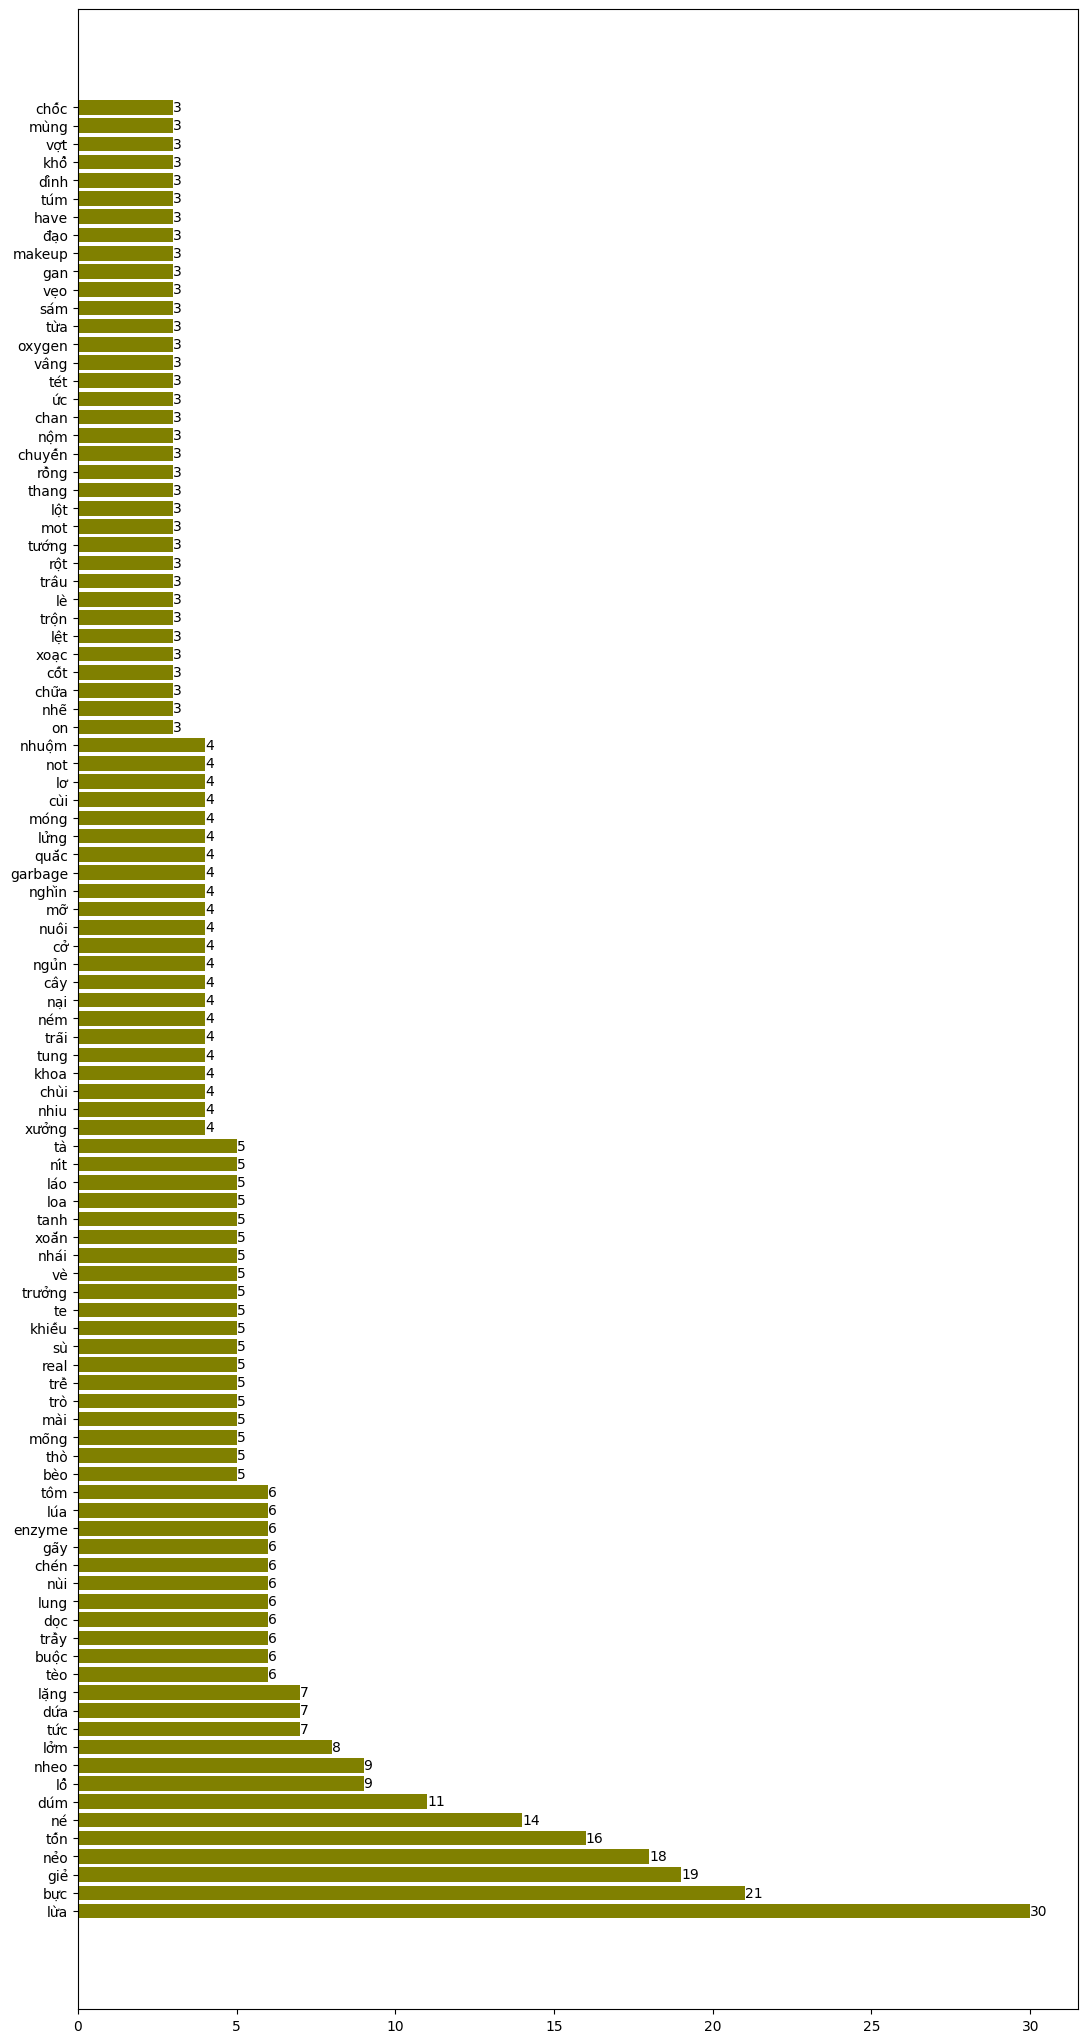

In [18]:
# negative words
Detective.wordFrequencyBarplot(neg_words.head(100))

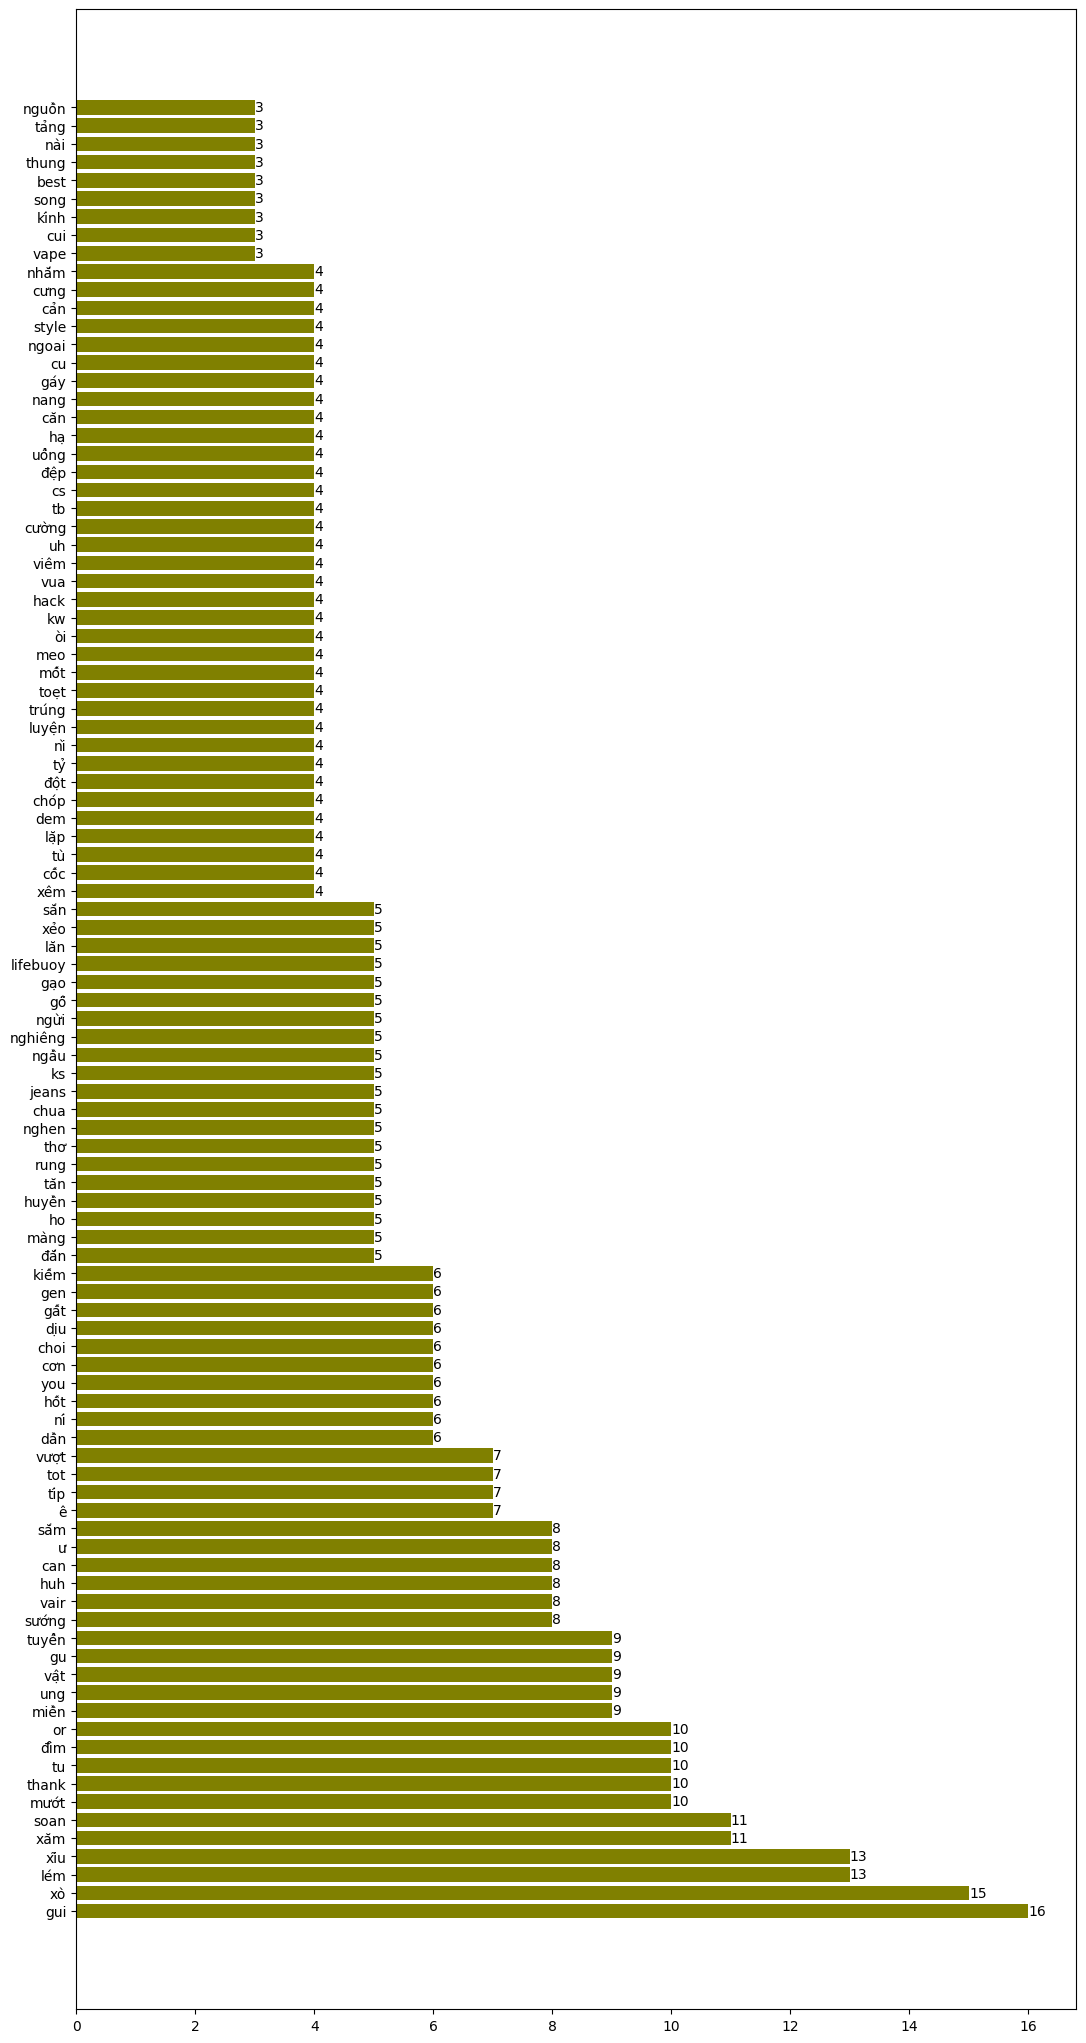

In [19]:
# positive word
Detective.wordFrequencyBarplot(pos_words.head(100))

> **Nhận xét**:
> * Các unique words này thể hiện đúng tính chất của một comment tương ứng với class đó.

Bây giờ ta sẽ xem xét 50 từ đầu tiên chồng chéo trên cả hai class.

In [20]:
print(f"Amount of overlap words: {len(inter_words)}")

Amount of overlap words: 2097


In [22]:
Detective.barplotTwoDirections(inter_words.head(50))

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

50 từ chồng chéo thuộc đoạn $[800,850]$ trên cả hai class

In [ ]:
Detective.barplotTwoDirections(inter_words.loc[800:850, :])

> **Nhận xét**:
> * Một điều đáng mừng là các overlap word này đa phần nghiêng hẳng về một bên, điều này giúp cho model có khả năng tránh bị bối rối khi phải đưa ra quyết định khi gặp các từ này.

Ở phần gần cuối này, chúng ta sẽ tập trung vào việc tìm kiếm các từ ghép khả dỉ đang tồn tại trong dataset. Hay còn gọi là NGrams

In [19]:
compounds_freq, compounds_dash = Detective.genCompoundWords(reviews['normalize_comment'], [2, 3, 4])

print(f"Have {len(compounds_dash)} compounds words in the dataset")

Have 358857 compounds words in the dataset


Chúng ta có thể xem 100 từ ghép phổ biến và tần số xuất hiện của chúng, chúng ta cũng có thể xem 100 từ ghép ít phổ biến nhất nhưng điều này cá nhân tôi thấy không cần thiết vì tôi bảo đảm chúng toàn là có tần số là 1 thôi.

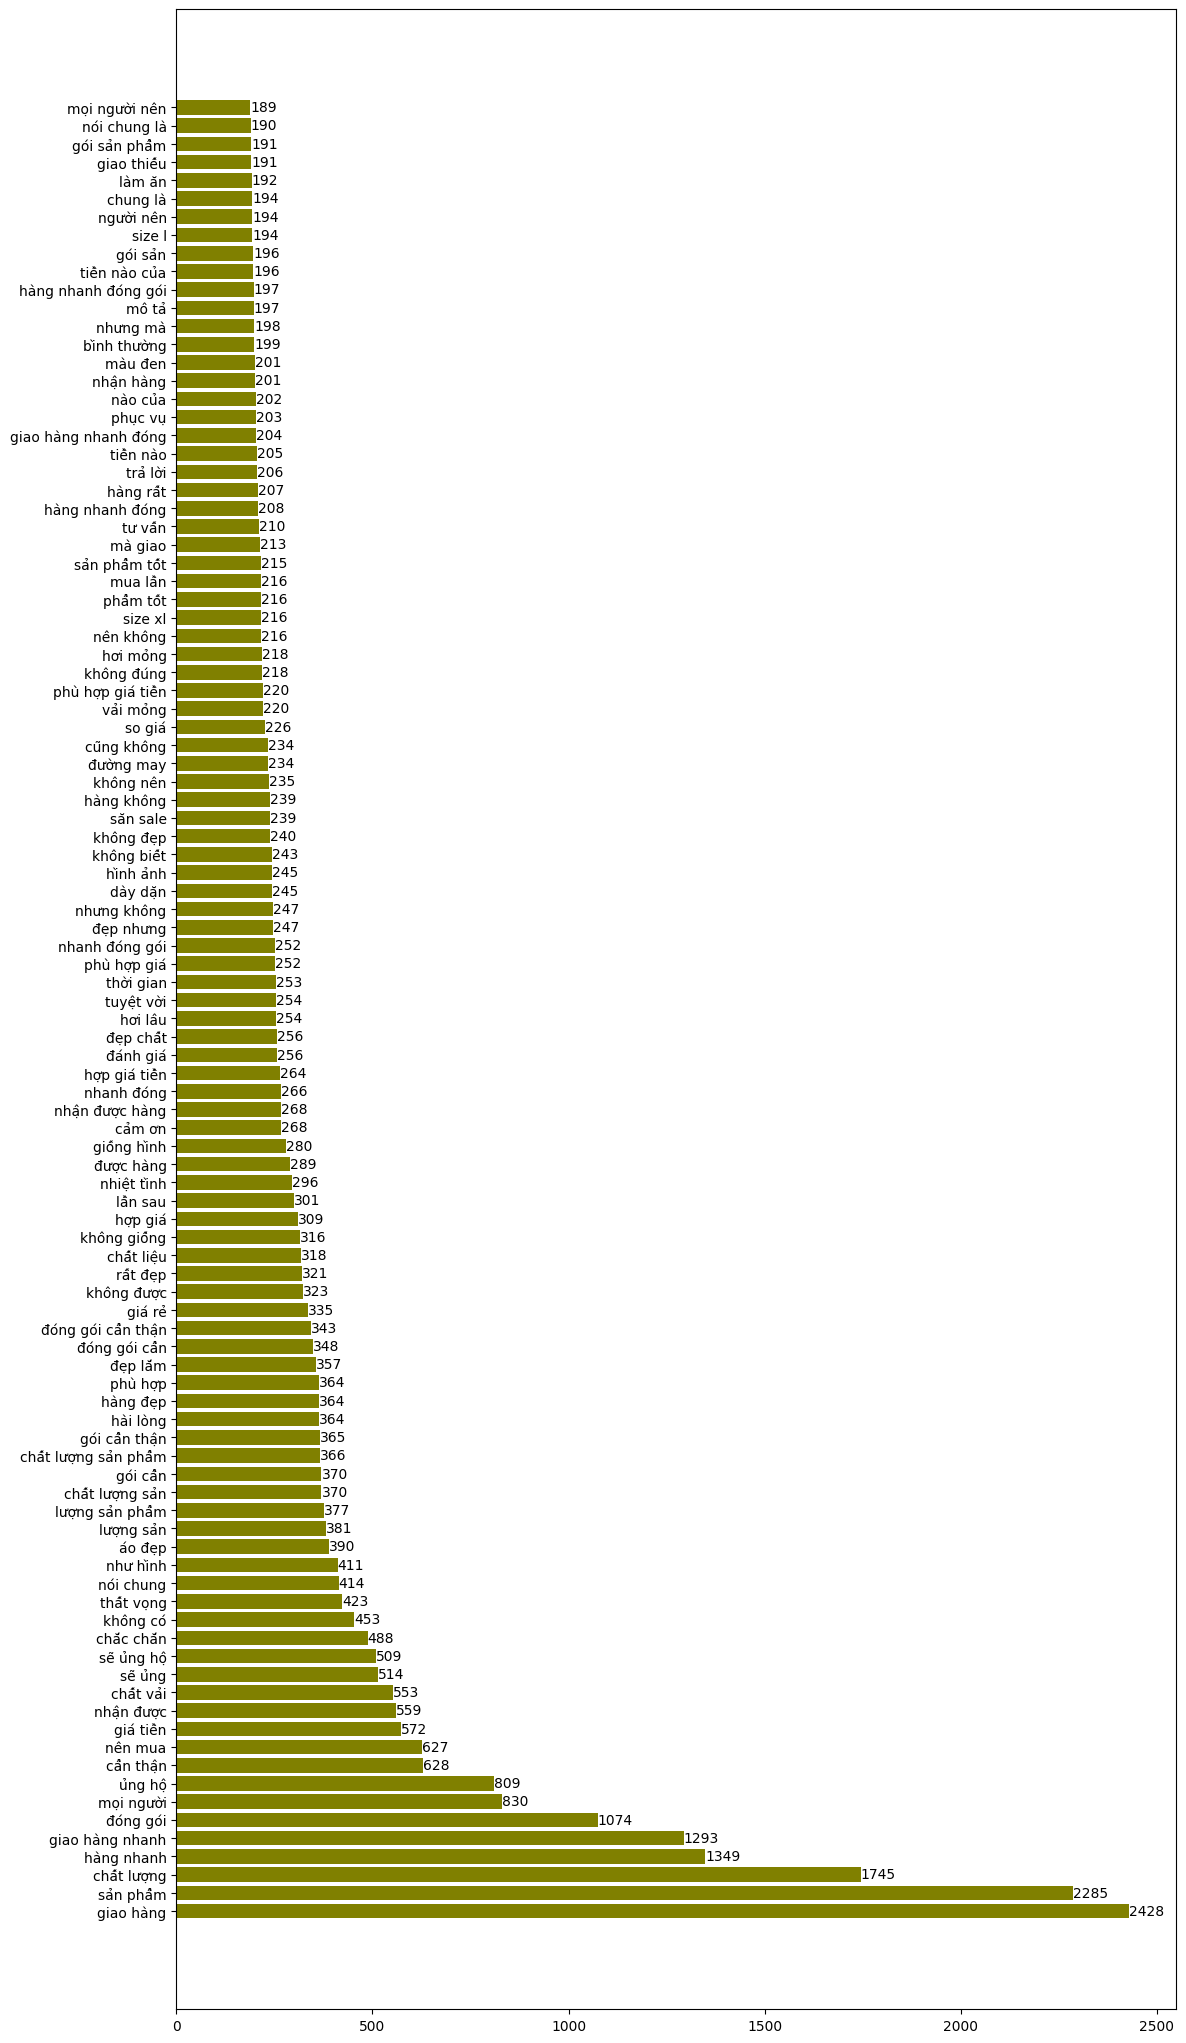

In [20]:
Detective.wordFrequencyBarplot(compounds_freq.head(100))

> **Nhận xét**:
> * Ở đây, chúng ta thử tìm các từ ghép phổ biến với n-gram $\in [2, 4]$.
> * Nhìn chung kết quả rất hợp lí, ta có thể thay các khoảng trắng trong các từ ghép này bằng underscore (_) và xem nó là một từ, điểm lợi là giúp cho model của ta thông tin hơn đồng thời cũng giảm tải đi dimention input đầu vào cũng như tránh sparse matrix quá lớn.